Importing required libraries and combining CSV files (concacted for easy process,chosen this method,unable to do seperate data preprocessing)

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tabulate import tabulate


combining both test&train datasets

In [ ]:
# Combine Test.csv and Train.csv

test_df = pd.read_csv('Test.csv')
train_df = pd.read_csv('Train.csv')
bigmart_df = pd.concat([train_df, test_df], ignore_index=True)
bigmart_df.to_csv('bigmart.csv', index=False)

# Load the combined dataset
df = pd.read_csv('bigmart.csv')


Performing exploratory data analysis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14204 non-null  object 
 1   Item_Weight                11765 non-null  float64
 2   Item_Fat_Content           14204 non-null  object 
 3   Item_Visibility            14204 non-null  float64
 4   Item_Type                  14204 non-null  object 
 5   Item_MRP                   14204 non-null  float64
 6   Outlet_Identifier          14204 non-null  object 
 7   Outlet_Establishment_Year  14204 non-null  int64  
 8   Outlet_Size                10188 non-null  object 
 9   Outlet_Location_Type       14204 non-null  object 
 10  Outlet_Type                14204 non-null  object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 1.3+ MB
None
        Item_Weight  Item_Visibility    

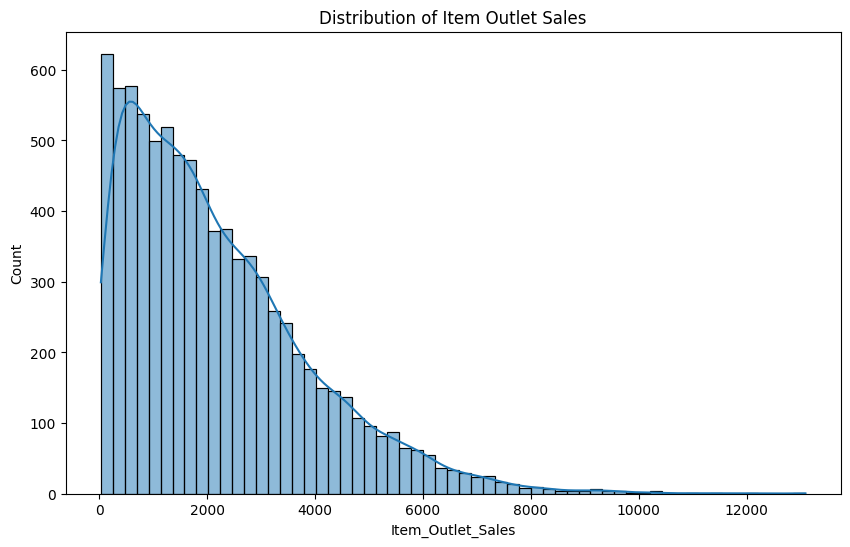

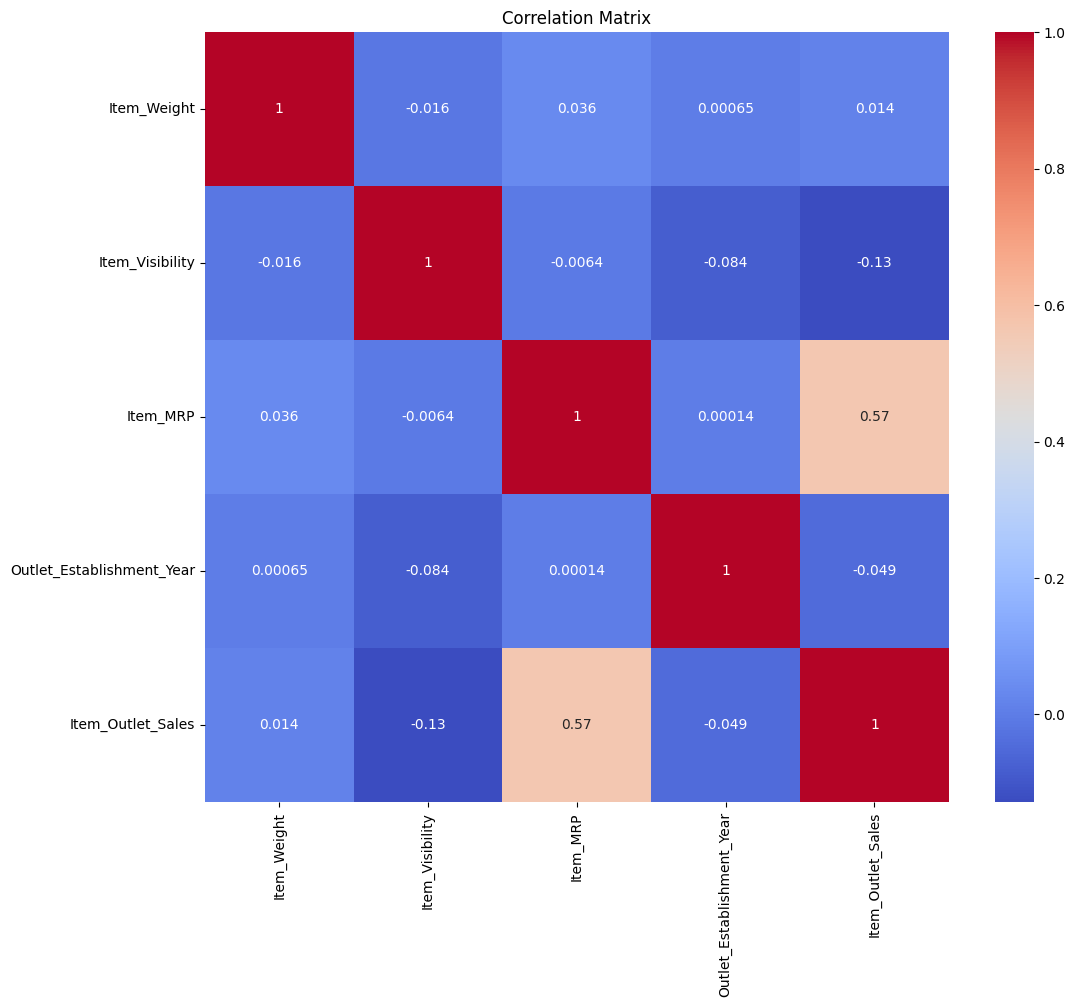

In [6]:
# Displaying basic information about the dataset
print(df.info())

# Displaying summary statistics
print(df.describe())

# Checking for missing values if any...
print(df.isnull().sum())

# Visualizing  the distribution of the target variable (Item_Outlet_Sales)
plt.figure(figsize=(10, 6))
sns.histplot(df['Item_Outlet_Sales'], kde=True)
plt.title('Distribution of Item Outlet Sales')
plt.show()

# Selecting only numeric columns before calculating correlations
numeric_df = df.select_dtypes(include=np.number)

# Visualize the correlation matrix for numeric columns only
plt.figure(figsize=(12, 10))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


Performing feature engineering, feature selection, and train-test split

In [17]:
# Function to detect and remove outliers using the IQR method
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]


In [18]:
# Handle missing values
df['Item_Weight'].fillna(df['Item_Weight'].mean(), inplace=True)
df['Outlet_Size'].fillna(df['Outlet_Size'].mode()[0], inplace=True)

# **Impute missing values in 'Item_Outlet_Sales' with the mean**
df['Item_Outlet_Sales'].fillna(df['Item_Outlet_Sales'].mean(), inplace=True)

# Encode categorical variables
le = LabelEncoder()
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Feature selection (using correlation with target variable)
correlation_with_target = df.corr()['Item_Outlet_Sales'].abs().sort_values(ascending=False)
selected_features = correlation_with_target[1:6].index.tolist()

# Prepare features and target
X = df[selected_features]
y = df['Item_Outlet_Sales']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


<ipython-input-18-0f0fee366030>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Item_Weight'].fillna(df['Item_Weight'].mean(), inplace=True)
<ipython-input-18-0f0fee366030>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

In [20]:
def evaluate_model(model, model_name, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"\n{model_name} Results:")
    print(f"Parameters: {model.get_params()}")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared Score: {r2}")
    # Return the results to be stored
    return model_name, mse, r2

# Initialize an empty list to store the results
results = []

# 1. AdaBoost Regressor
adaboost_params = {
    'n_estimators': 100,
    'learning_rate': 0.5,
    'random_state': 42,
}
adaboost = AdaBoostRegressor(**adaboost_params)
adaboost.fit(X_train, y_train)
# Append the results to the list
results.append(evaluate_model(adaboost, "AdaBoost", X_test, y_test))

# 2. Gradient Boosting Regressor
gbm_params = {
    'n_estimators': 200,
    'learning_rate': 0.1,
    'max_depth': 3,
    'random_state': 42,
}
gbm = GradientBoostingRegressor(**gbm_params)
gbm.fit(X_train, y_train)
# Append the results to the list
results.append(evaluate_model(gbm, "Gradient Boosting", X_test, y_test))

# 3. XGBoost Regressor
xgb_params = {
    'n_estimators': 150,
    'learning_rate': 0.1,
    'max_depth': 4,
    'random_state': 42,
}
xgb = XGBRegressor(**xgb_params)
xgb.fit(X_train, y_train)
# Append the results to the list
results.append(evaluate_model(xgb, "XGBoost", X_test, y_test))


AdaBoost Results:
Parameters: {'estimator': None, 'learning_rate': 0.5, 'loss': 'linear', 'n_estimators': 100, 'random_state': 42}
Mean Squared Error: 1290268.6829167204
R-squared Score: 0.19468106962779808

Gradient Boosting Results:
Parameters: {'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Mean Squared Error: 1080104.0391904898
R-squared Score: 0.3258549625762539

XGBoost Results:
Parameters: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'ear

tabulating the results and evaluate the best suited model

In [22]:
# Display results in a table
headers = ["Model", "Mean Squared Error", "R-squared Score"]
print("\nResults Table:")
print(tabulate(results, headers=headers, tablefmt="grid"))

# Identify the best model based on MSE
best_model = min(results, key=lambda x: x[1])
print(f"\nBest performing model based on MSE: {best_model[0]}")


Results Table:
+-------------------+----------------------+-------------------+
| Model             |   Mean Squared Error |   R-squared Score |
+===================+======================+===================+
| AdaBoost          |          1.29027e+06 |          0.194681 |
+-------------------+----------------------+-------------------+
| Gradient Boosting |          1.0801e+06  |          0.325855 |
+-------------------+----------------------+-------------------+
| XGBoost           |          1.08446e+06 |          0.323135 |
+-------------------+----------------------+-------------------+

Best performing model based on MSE: Gradient Boosting


Best performing model based on MSE: Gradient Boosting